In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error

In [2]:
dfCCO = pd.read_csv(r"..\Data\cco_cost_monthly.csv")

In [3]:
dfPYCO = pd.read_csv(r"..\Data\pyco_cost_monthly.csv", low_memory=False)

In [4]:
dfXCO = pd.read_csv(r"..\Data\xco_cost_monthly.csv")

In [5]:
def process_data(df):
    return df.groupby("invoice_month").agg({"total_cost": "sum"})

In [6]:
dfPYCO_processed = process_data(dfPYCO)
dfXCO_processed = process_data(dfXCO)
dfCCO_processed = process_data(dfCCO)

In [43]:
len(dfPYCO_processed)

15

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

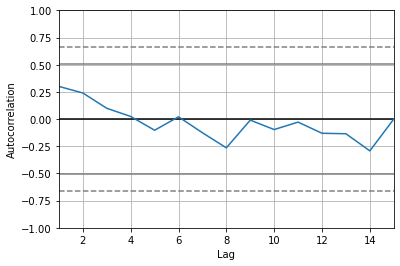

In [7]:
pd.plotting.autocorrelation_plot(dfPYCO_processed)

                               SARIMAX Results                                
Dep. Variable:             total_cost   No. Observations:                   15
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -121.325
Date:                Tue, 27 Apr 2021   AIC                            254.649
Time:                        10:46:07   BIC                            258.483
Sample:                    09-01-2019   HQIC                           254.294
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2791      0.593     -0.471      0.638      -1.441       0.883
ar.L2         -0.2124      0.772     -0.275      0.783      -1.726       1.302
ar.L3         -0.2580      0.635     -0.406      0.6

C:\Users\irvin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\irvin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\irvin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\irvin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


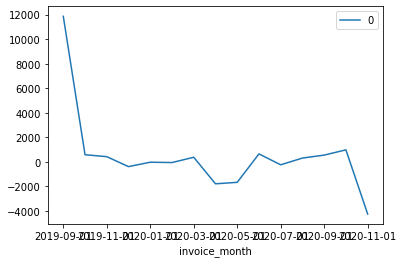

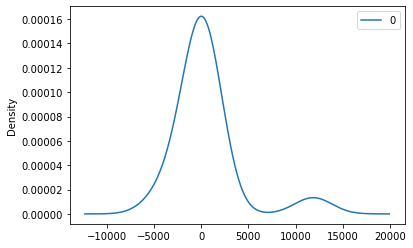

                  0
count     15.000000
mean     494.235051
std     3420.766851
min    -4243.347290
25%     -306.729948
50%      316.267682
75%      573.105308
max    11868.213465


In [8]:
model = ARIMA(dfPYCO_processed, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [25]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.80)
    train, test = X.total_cost[0:train_size], X.total_cost[train_size:]
    history = train.to_list()
    test = test.to_list()
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mae = mean_absolute_error(test, predictions)
    return mae

In [37]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mae = evaluate_arima_model(dataset, order)
                    if mae < best_score:
                        best_score, best_cfg = mae, order
                    print('ARIMA%s MAE=%.3f' % (order,mae))
                except:
                    continue
    print('Best ARIMA%s MAE=%.3f' % (best_cfg, best_score))

In [38]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
p_range = range(4)
d_range = range(4)
q_range = range(4)

evaluate_models(dfCCO_processed, p_range, d_range, q_range)

ARIMA(0, 0, 0) MAE=281.117
ARIMA(0, 0, 1) MAE=364.254
ARIMA(0, 0, 2) MAE=263.057
ARIMA(0, 0, 3) MAE=201.614
ARIMA(0, 1, 0) MAE=13.425
ARIMA(0, 1, 1) MAE=99.445
ARIMA(0, 1, 2) MAE=225.865
ARIMA(0, 1, 3) MAE=99.506
ARIMA(0, 2, 0) MAE=148.774
ARIMA(0, 2, 1) MAE=235.552
ARIMA(0, 2, 2) MAE=262.996
ARIMA(0, 2, 3) MAE=246.612
ARIMA(0, 3, 0) MAE=419.898
ARIMA(0, 3, 1) MAE=292.009
ARIMA(0, 3, 2) MAE=334.674
ARIMA(0, 3, 3) MAE=366.394
ARIMA(1, 0, 0) MAE=164.258
ARIMA(1, 0, 1) MAE=123.687
ARIMA(1, 0, 2) MAE=201.192
ARIMA(1, 0, 3) MAE=165.359
ARIMA(1, 1, 0) MAE=52.292
ARIMA(1, 1, 1) MAE=239.402
ARIMA(1, 1, 2) MAE=159.342
ARIMA(1, 1, 3) MAE=205.392
ARIMA(1, 2, 0) MAE=277.288
ARIMA(1, 2, 1) MAE=247.308
ARIMA(1, 2, 2) MAE=205.046
ARIMA(1, 2, 3) MAE=246.476
ARIMA(1, 3, 0) MAE=320.997
ARIMA(1, 3, 1) MAE=361.306
ARIMA(1, 3, 2) MAE=278.132
ARIMA(1, 3, 3) MAE=311.591
ARIMA(2, 0, 0) MAE=180.972
ARIMA(2, 0, 1) MAE=179.329
ARIMA(2, 0, 2) MAE=159.731
ARIMA(2, 0, 3) MAE=141.673
ARIMA(2, 1, 0) MAE=130.157
ARIMA

In [40]:
p_range = range(6)
d_range = range(4)
q_range = range(4)

evaluate_models(dfPYCO_processed, p_range, d_range, q_range)

ARIMA(0, 0, 0) MAE=1684.609
ARIMA(0, 0, 1) MAE=1755.722
ARIMA(0, 0, 2) MAE=2077.263
ARIMA(0, 1, 0) MAE=2132.703
ARIMA(0, 1, 1) MAE=2138.033
ARIMA(0, 1, 2) MAE=2031.945
ARIMA(0, 2, 0) MAE=2130.603
ARIMA(0, 2, 1) MAE=2138.017
ARIMA(0, 2, 2) MAE=2131.694
ARIMA(0, 3, 0) MAE=2435.132
ARIMA(0, 3, 1) MAE=2160.036
ARIMA(0, 3, 2) MAE=2257.110
ARIMA(1, 0, 0) MAE=2000.355
ARIMA(1, 0, 1) MAE=2064.943
ARIMA(1, 0, 2) MAE=1955.637
ARIMA(1, 1, 0) MAE=2136.629
ARIMA(1, 1, 1) MAE=2182.684
ARIMA(1, 1, 2) MAE=2027.486
ARIMA(1, 2, 0) MAE=2183.122
ARIMA(1, 2, 1) MAE=2054.243
ARIMA(1, 2, 2) MAE=2136.448
ARIMA(1, 3, 0) MAE=2509.074
ARIMA(1, 3, 1) MAE=2316.774
ARIMA(1, 3, 2) MAE=19670.353
ARIMA(2, 0, 0) MAE=2083.518
ARIMA(2, 0, 1) MAE=2166.151
ARIMA(2, 0, 2) MAE=1842.251
ARIMA(2, 1, 0) MAE=2146.714
ARIMA(2, 1, 1) MAE=2033.258
ARIMA(2, 1, 2) MAE=2108.066
ARIMA(2, 2, 0) MAE=2213.344
ARIMA(2, 2, 1) MAE=2106.989
ARIMA(2, 2, 2) MAE=2503.360
ARIMA(2, 3, 0) MAE=2379.080
ARIMA(2, 3, 1) MAE=2332.649
ARIMA(2, 3, 2) MAE=

In [41]:
p_range = range(6)
d_range = range(4)
q_range = range(4)

evaluate_models(dfXCO_processed, p_range, d_range, q_range)

ARIMA(0, 0, 0) MAE=979.281
ARIMA(0, 0, 1) MAE=766.462
ARIMA(0, 0, 2) MAE=494.024
ARIMA(0, 0, 3) MAE=498.183
ARIMA(0, 1, 0) MAE=433.965
ARIMA(0, 1, 1) MAE=442.251
ARIMA(0, 1, 2) MAE=523.570
ARIMA(0, 2, 0) MAE=349.404
ARIMA(0, 2, 1) MAE=619.974
ARIMA(0, 2, 2) MAE=722.227
ARIMA(0, 3, 0) MAE=618.520
ARIMA(0, 3, 1) MAE=321.697
ARIMA(0, 3, 2) MAE=452.900
ARIMA(1, 0, 0) MAE=325.687
ARIMA(1, 0, 1) MAE=306.825
ARIMA(1, 0, 2) MAE=405.702
ARIMA(1, 0, 3) MAE=349.491
ARIMA(1, 1, 0) MAE=447.986
ARIMA(1, 1, 1) MAE=498.138
ARIMA(1, 1, 2) MAE=442.272
ARIMA(1, 2, 0) MAE=524.954
ARIMA(1, 2, 1) MAE=662.632
ARIMA(1, 2, 2) MAE=723.033
ARIMA(1, 3, 0) MAE=706.902
ARIMA(1, 3, 1) MAE=514.693
ARIMA(1, 3, 2) MAE=601.376
ARIMA(2, 0, 0) MAE=300.180
ARIMA(2, 0, 1) MAE=333.801
ARIMA(2, 0, 2) MAE=412.990
ARIMA(2, 0, 3) MAE=587.341
ARIMA(2, 1, 0) MAE=526.303
ARIMA(2, 1, 1) MAE=588.846
ARIMA(2, 1, 2) MAE=452.461
ARIMA(2, 2, 0) MAE=606.824
ARIMA(2, 2, 1) MAE=633.188
ARIMA(2, 2, 2) MAE=697.283
ARIMA(2, 3, 0) MAE=636.585
A